In [1]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import xesmf as xe
import xgcm

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:35945 Dashboard: /proxy/8787/status,Cluster Workers: 7 Cores: 28 Memory: 250.00 GiB


In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'

ti = '2150-01-01'
tf = '2164-12-31'

# Time mean last 5 years

In [ ]:
tx = {}
tx['ctrl'] = cc.querying.getvar(experiment_ryf, 'tx_trans_rho', session_ryf, start_time = ti, end_time = tf).sel(grid_yt_ocean = slice(None, -50)).mean('time')
tx['up'] = cc.querying.getvar(experiment_eup, 'tx_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yt_ocean = slice(None, -50)).mean('time')
tx['down'] = cc.querying.getvar(experiment_edo, 'tx_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yt_ocean = slice(None, -50)).mean('time')

ty = {}
ty['ctrl'] = cc.querying.getvar(experiment_ryf, 'ty_trans_rho', session_ryf, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50)).mean('time')
ty['up'] = cc.querying.getvar(experiment_eup, 'ty_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50)).mean('time')
ty['down'] = cc.querying.getvar(experiment_edo, 'ty_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50)).mean('time')

## Regrid ty to tx coordinates

`grid_yu_ocean` --> `grid_yt_ocean`

In [6]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [7]:
ds_out = grid['hu'].sel(yu_ocean = slice(-80,-58)).drop('geolon_c').drop('geolat_c').chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()
for k in ['up', 'down']:
    ds_in = tx[k].rename({'grid_xu_ocean':'xu_ocean', 'grid_yt_ocean':'yu_ocean'}).chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    tx[k] = dr_out['tx_trans_rho']
    
    ds_in = ty[k].rename({'grid_xt_ocean':'xu_ocean', 'grid_yu_ocean':'yu_ocean'}).chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    ty[k] = dr_out['ty_trans_rho']

# Calculate cross-slope transport

In [9]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = grid.copy()
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_x = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid_x.interp( grid_x.diff(ds.hu, 'X') / grid_x.interp(ds.dxu, 'X'), 'X')
# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid_x.interp( grid_x.diff(ds.hu, 'Y', boundary='extend') / grid_x.interp(ds.dyt, 'X'), 'Y', boundary='extend')
# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

In [13]:
dhu_dx = dhu_dx.sel(yu_ocean = tx['up']['yu_ocean'])
dhu_dy = dhu_dy.sel(yu_ocean = tx['up']['yu_ocean'])
topographic_slope_magnitude = topographic_slope_magnitude.sel(yu_ocean = tx['up']['yu_ocean'])

In [14]:
t_projected = {}
for k in ['up', 'down']:
    t_projected[k] = tx[k]*dhu_dx/topographic_slope_magnitude + ty[k]*dhu_dy/topographic_slope_magnitude

Wilma's code:

In [15]:
isobath_depth = 1500
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)
# We are interested in the u-grid:
num_points = data['num_points_u']
distance_along_contour = data['distance_along_contour_u']
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

In [19]:
# Only run this once
for k in ['down']:
    t_across_contour = np.zeros((len(t_projected[k]['potrho']), len(lon_along_contour)))
    tx_across = t_projected[k].compute()
    
    for ii in range(num_points):
        t_across_contour[:,ii] = tx_across.sel(xu_ocean = lon_along_contour[ii], method = 'nearest').sel(yu_ocean = lat_along_contour[ii], method = 'nearest').values            
    
    t_across_contour = xr.DataArray(t_across_contour, dims = {'lon_along_contour', 'potrho'}, 
                             coords = {'lon_along_contour':lon_along_contour, 'potrho':tx['ctrl']['potrho']})
    t_across_contour.to_netcdf('transport_across_topograd_'+k+'.nc')

In [25]:
tr_across_slope = {}
for k in ['ctrl', 'up', 'down']:
    tr_across_slope[k] = xr.open_dataset('transport_across_topograd_'+k+'.nc')['__xarray_dataarray_variable__']

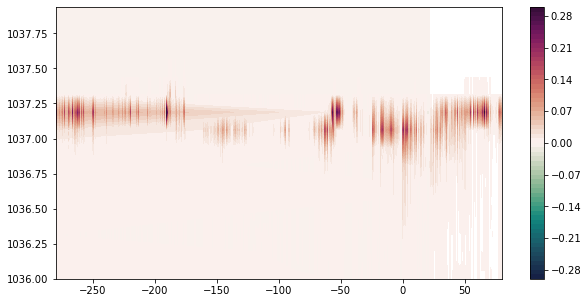

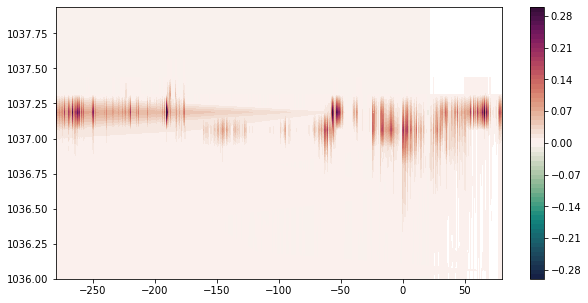

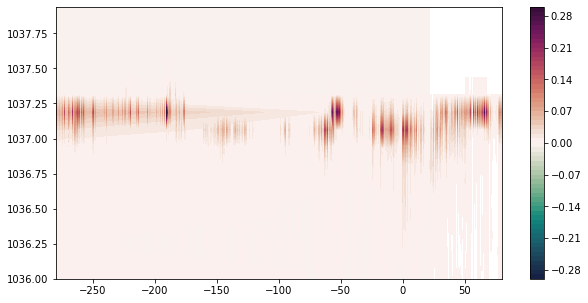

In [37]:
for k in ['ctrl', 'up', 'down']:
    plt.figure(figsize = (10,5))
    plt.contourf(tr_across_slope[k]['lon_along_contour'], tr_across_slope[k]['potrho'], tr_across_slope[k]/(1e6*1035),
                 levels = np.arange(-0.3, 0.31, .01), cmap = cmocean.cm.curl)
    plt.ylim(1036, None)
    plt.colorbar()

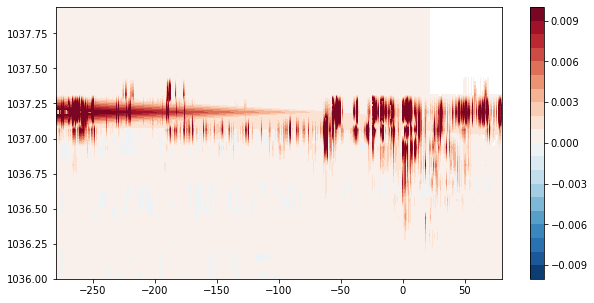

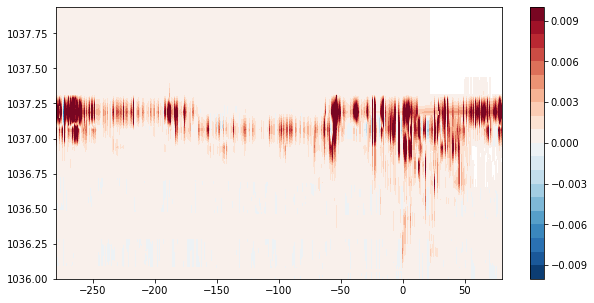

In [39]:
for k in ['up', 'down']:
    plt.figure(figsize = (10,5))
    plt.contourf(tr_across_slope[k]['lon_along_contour'], tr_across_slope[k]['potrho'], (tr_across_slope[k]-tr_across_slope['ctrl'])/(1e6*1035),
                 levels = np.arange(-0.01, 0.011, .001), cmap = 'RdBu_r')
    plt.ylim(1036, None)
    plt.colorbar()

# Time series

Trying doing it with 1 year chunks, if not I don't have enough memory

In [28]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
ds_out = grid['hu'].sel(yu_ocean = slice(-80,-58)).drop('geolon_c').drop('geolat_c').chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()

In [11]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = grid.copy()
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_x = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid_x.interp( grid_x.diff(ds.hu, 'X') / grid_x.interp(ds.dxu, 'X'), 'X')
# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid_x.interp( grid_x.diff(ds.hu, 'Y', boundary='extend') / grid_x.interp(ds.dyt, 'X'), 'Y', boundary='extend')
# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

dhu_dx = dhu_dx.sel(yu_ocean = tx['ctrl']['yu_ocean'])
dhu_dy = dhu_dy.sel(yu_ocean = tx['ctrl']['yu_ocean'])
topographic_slope_magnitude = topographic_slope_magnitude.sel(yu_ocean = tx['ctrl']['yu_ocean'])

In [16]:
isobath_depth = 1500
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)
# We are interested in the u-grid:
num_points = data['num_points_u']
distance_along_contour = data['distance_along_contour_u']
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

In [ ]:
for k in ['up', 'down']:
    if k == 'ctrl':
        exp = experiment_ryf
        ses = session_ryf
    elif k == 'up':
        exp = experiment_eup
        ses = session_eas
    else:
        exp = experiment_edo
        ses = session_eas
        
    for y in range(2150, 2166, 1):
        
        # Time range range
        ti = str(y)+'-01-01'
        tf = str(y)+'-12-31'
        
        # Open transport
        tx = cc.querying.getvar(exp, 'tx_trans_rho', ses, start_time = ti, end_time = tf).sel(time = slice(ti, tf), grid_yt_ocean = slice(-80, -58))
        ty = cc.querying.getvar(exp, 'ty_trans_rho', ses, start_time = ti, end_time = tf).sel(time = slice(ti, tf), grid_yu_ocean = slice(-80, -58))
        
        # Regrid
        ds_in = tx.rename({'grid_xu_ocean':'xu_ocean', 'grid_yt_ocean':'yu_ocean'}).chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()
        regrid = xe.Regridder(ds_in, ds_out, 'conservative')
        dr_out = regrid(ds_in)
        tx = dr_out['tx_trans_rho']
        ds_in = ty.rename({'grid_xt_ocean':'xu_ocean', 'grid_yu_ocean':'yu_ocean'}).chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()
        regrid = xe.Regridder(ds_in, ds_out, 'conservative')
        dr_out = regrid(ds_in)
        ty = dr_out['ty_trans_rho']
        
        # Transport across the topographic gradient
        t_proj = (tx*dhu_dx/topographic_slope_magnitude + ty*dhu_dy/topographic_slope_magnitude)
        tx_across = t_proj.load()
        
        t_across_contour = np.zeros((len(t_proj['time']), len(t_proj['potrho']), len(lon_along_contour)))
        for ii in range(num_points):
            t_across_contour[:, :, ii] = t_proj.sel(xu_ocean = lon_along_contour[ii], method = 'nearest').sel(yu_ocean = lat_along_contour[ii], method = 'nearest')            

        del tx_across # Clear memory

        t_across_contour = xr.DataArray(t_across_contour, dims = {'time', 'lon_along_contour', 'potrho'}, 
                                 coords = {'time':t_proj['time'], 'lon_along_contour':lon_along_contour, 'potrho':t_proj['potrho']})
        t_across_contour.to_netcdf('transport_across_topograd_'+k+str(y)+'.nc')

# Calculate cross-slope transport

In [15]:
t_projected = {}
for k in ['ctrl']:
    t_projected[k] = (tx[k]*dhu_dx/topographic_slope_magnitude + ty[k]*dhu_dy/topographic_slope_magnitude)

Wilma's code:

In [17]:
t_projected[k]

,Array,Chunk
Bytes,16.19 GiB,110.46 MiB
Shape,"(15, 80, 503, 3600)","(1, 8, 503, 3598)"
Count,71778 Tasks,450 Chunks
Type,float64,numpy.ndarray


In [19]:
# Only run this once
for k in ['ctrl']:#, 'up', 'down']:
    t_across_contour = np.zeros((len(t_projected[k]['time']), len(t_projected[k]['potrho']), len(lon_along_contour)))
    tx_across = t_projected[k].load()
    
    for ii in range(num_points):
        t_across_contour[:, :, ii] = t_projected[k].sel(xu_ocean = lon_along_contour[ii], method = 'nearest').sel(yu_ocean = lat_along_contour[ii], method = 'nearest').values            
    
    del tx_across # Clear memory
    
    t_across_contour = xr.DataArray(t_across_contour, dims = {'time', 'lon_along_contour', 'potrho'}, 
                             coords = {'time':t_projected[k]['time'], 'lon_along_contour':lon_along_contour, 'potrho':tx['ctrl']['potrho']})
    t_across_contour.to_netcdf('transport_across_topograd_'+k+str(2150)+'.nc')